In [1]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt


2023-01-12 01:08:57.454857: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 01:08:58.116652: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/matikd/miniconda3/envs/tf/lib/
2023-01-12 01:08:58.117954: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/matikd/miniconda3/envs/tf/lib/
2023-01-12 01:08:58.117962: W tensorflow/compiler/tf2t

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
data_dir = 'data'
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [4]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [5]:
data = tf.keras.utils.image_dataset_from_directory(data_dir) #0 kielecki, 1 winiary
data_iterator = data.as_numpy_iterator()

Found 174 files belonging to 2 classes.


In [6]:
batch = data_iterator.next()

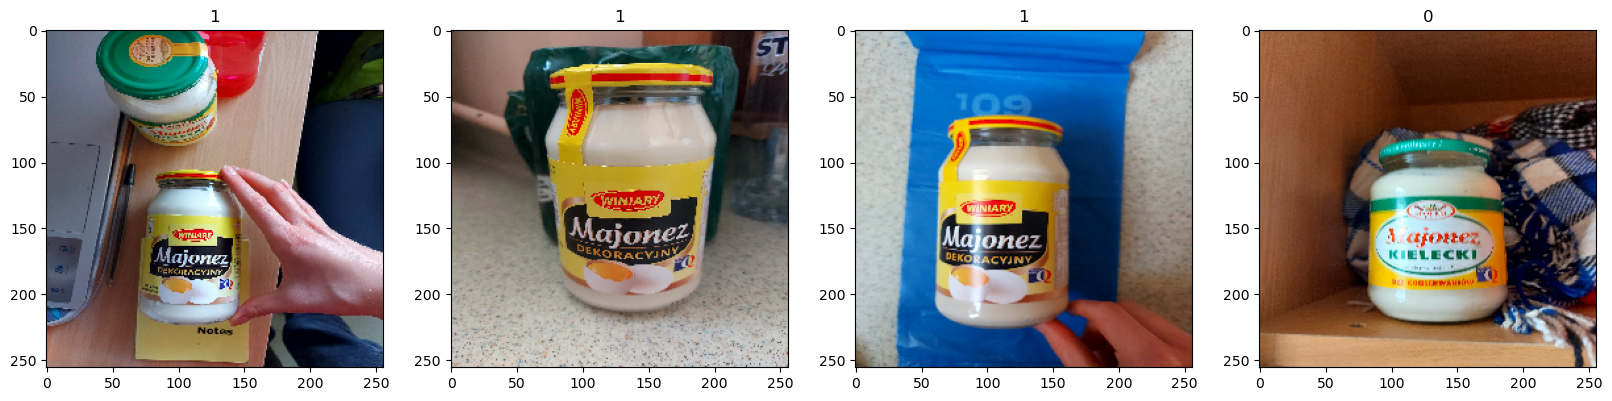

In [7]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [8]:
data = data.map(lambda x,y: (x/255, y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [9]:
data.as_numpy_iterator().next()

(array([[[[1.09301277e-01, 1.06384993e-01, 1.25490203e-01],
          [1.08438648e-01, 1.04517080e-01, 1.24124922e-01],
          [9.79176238e-02, 1.23040169e-01, 1.32966638e-01],
          ...,
          [3.74355674e-01, 5.01285791e-01, 7.04165697e-01],
          [4.69831884e-01, 5.63244879e-01, 7.54298806e-01],
          [4.15949553e-01, 5.25753498e-01, 7.21831918e-01]],
 
         [[2.38493800e-01, 1.83591828e-01, 1.75013408e-01],
          [2.55922556e-01, 1.85334325e-01, 1.80104926e-01],
          [2.49794155e-01, 1.79205924e-01, 1.66705921e-01],
          ...,
          [4.15686280e-01, 5.33333361e-01, 7.45098054e-01],
          [4.66094136e-01, 5.60210824e-01, 7.56391704e-01],
          [3.75612736e-01, 4.81495112e-01, 6.89338207e-01]],
 
         [[3.93689692e-01, 3.17772478e-01, 3.02789897e-01],
          [3.93318206e-01, 3.21504474e-01, 2.96627015e-01],
          [3.48706543e-01, 2.74196744e-01, 2.50667304e-01],
          ...,
          [4.44765806e-01, 5.34961879e-01, 7.3888

In [10]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)

In [11]:
train_size+val_size+test_size == len(data)

True

In [12]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

Model:

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [14]:
model = Sequential()

In [15]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [16]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

Trenowanie

In [19]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [20]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 8s 710ms/step - loss: 1.0103 - accuracy: 0.5312 - val_loss: 0.7721 - val_accuracy: 0.4348
Epoch 2/20
4/4 [==============================] - 3s 580ms/step - loss: 0.7114 - accuracy: 0.5000 - val_loss: 0.6664 - val_accuracy: 0.5435
Epoch 3/20
4/4 [==============================] - 4s 577ms/step - loss: 0.6659 - accuracy: 0.6250 - val_loss: 0.6456 - val_accuracy: 0.7826
Epoch 4/20
4/4 [==============================] - 4s 619ms/step - loss: 0.6151 - accuracy: 0.7266 - val_loss: 0.4798 - val_accuracy: 0.8913
Epoch 5/20
4/4 [==============================] - 4s 578ms/step - loss: 0.4594 - accuracy: 0.8750 - val_loss: 0.3325 - val_accuracy: 0.8913
Epoch 6/20
4/4 [==============================] - 4s 643ms/step - loss: 0.3241 - accuracy: 0.9062 - val_loss: 0.3473 - val_accuracy: 0.8261
Epoch 7/20
4/4 [==============================] - 4s 610ms/step - loss: 0.2280 - accuracy: 0.8984 - val_loss: 0.2382 - val_accuracy: 0.8913
Epoch 8/20
4/4 [====

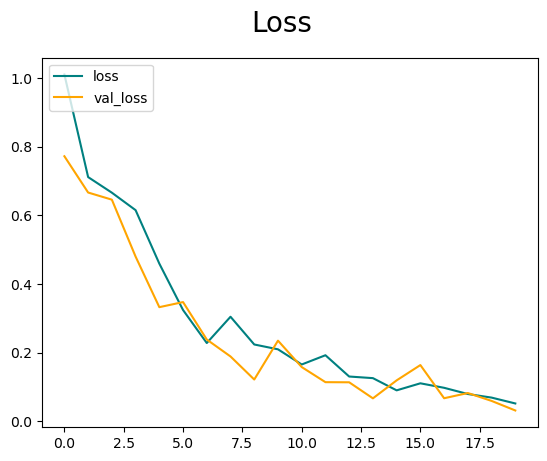

In [21]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

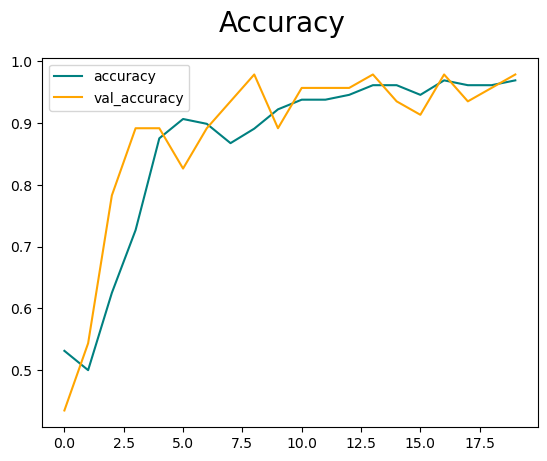

In [22]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Testowanie

In [24]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [25]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [26]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [27]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


Sprawdzenie

In [35]:
img = cv2.cvtColor(cv2.imread('kiel.jpg'), cv2.COLOR_BGR2RGB)

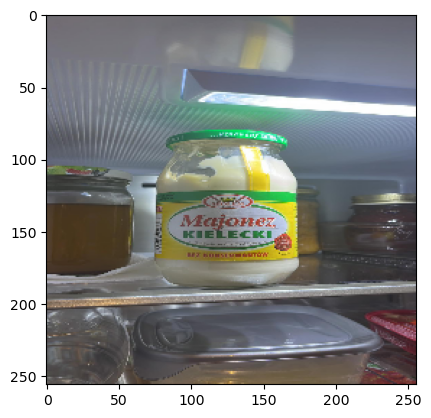

In [36]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [37]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 20ms/step


In [38]:
yhat

array([[0.00740584]], dtype=float32)

In [40]:
if yhat > 0.5:
    print(f'Winiary')
else:
    print(f'Kielecki')

Kielecki


In [41]:
from tensorflow.keras.models import load_model

In [42]:
model.save('majonez.h5')

In [44]:
new_model = load_model('majonez.h5')
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 59ms/step


array([[0.00740584]], dtype=float32)